# Mini Project 2

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**


###  Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed.


Investigate if the log returns of stocks or indexes of your choosing are normally distributed. Some suggestions for exploration include:

    1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.
    
    2) Test if removing extremal return data creates a distribution with evidence of being normal.
    
    3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.
    
    4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.
    
    5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import datetime as dt
from datetime import datetime, timedelta
sns.set_style('darkgrid')

import yfinance as yf
from tabulate import tabulate

The goal of this project is to assess whether the assumption that daily log-returns follow a normal distribution is a reasonable one. To this end, we will address a series of questions designed to provide evidence in support of this assumption

# Question 1: Are there any stocks or indices whose daily log-returns approximate a normal distribution over some time periods?

## Identifying Recent Market Stability

To answer this question, we first need to identify a period of overall market stability. To do this, we will consider a portfolio composed of the three major U.S. indices — the DJIA, S&P 500, and NASDAQ — and use a function to find the one-year time frame with the lowest volatility over the past five years.

In [2]:
big3 = ['^DJI', '^GSPC', '^IXIC']

# Function appneds the log-returns to the dataframe

def daily_return_app(portfolio):

    if 'Daily Log Return' in portfolio:

        return portfolio

    close = portfolio['Close']

    daily_return = np.log(close/close.shift(1))

    daily_return.columns = pd.MultiIndex.from_product([['Daily Log Return'], daily_return.columns])

    concat_df = pd.concat([portfolio, daily_return], axis = 1)

    return concat_df.dropna()

# Function takes in a set of tickers and outputs the year-long time frame between the start and end date each ticker had minimum volatility.
  
def lowest_vol(tickers, start_date, end_date):

    # Downloads historical price data
    
    tickers_data = yf.download(tickers, start = start_date, end = end_date)

    # Append the log daily returns to the data

    tickers_data = daily_return_app(tickers_data)

    num_days = (end_date - start_date).days

    # Initialize dictionaries to track the minimum volatility and the corresponding start day

    min_vol_cand = {ticker: 100 for ticker in tickers}
    min_vol_day = {ticker: 0 for ticker in tickers}
        
    for i in range(num_days - 365):

        # Extract 1-year window of daily log returns

        one_year_data = tickers_data.iloc[i:(365+i)]['Daily Log Return']
        
        # Compute annualized volatility for each ticker in the window
        
        one_year_vol = one_year_data.std()*np.sqrt(252)

        for ticker in tickers:

            # Update the minimum if a lower volatility is found
        
            if one_year_vol[ticker] < min_vol_cand[ticker]:

                min_vol_cand[ticker] = one_year_vol[ticker]
                min_vol_day[ticker] = i

    # Convert minimum day offsets to actual dates
    
    result = {
        ticker: (start_date + timedelta(days = int(min_vol_day[ticker])), min_vol_cand[ticker])
        for ticker in tickers
    }

    return result

lowest_vol(big3, datetime(2020, 5, 27), datetime(2025, 5, 27))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


{'^DJI': (datetime.datetime(2023, 11, 1, 0, 0), 0.06850281630180917),
 '^GSPC': (datetime.datetime(2023, 11, 1, 0, 0), 0.07055938441435212),
 '^IXIC': (datetime.datetime(2023, 10, 27, 0, 0), 0.10988107644332366)}

Judging by the result of this test, we conclude that the trading year beginning on November 1st, 2023, represents a relatively stable period for the market in the last 5 years. 

## Tests for Normality

We will test the daily log returns of the three major U.S. indices for normality to provide evidence that they are approximately normally distributed. To this end, we will apply two standard normality tests.

In [3]:
# Downloads historical data for the big three indices

big3_data = yf.download(big3, start = datetime(2023, 11, 1), end = datetime(2024, 11, 1))

# Appends the daily log returns to the dataframe

big3_data = daily_return_app(big3_data)

# Finds and prints the p-values for the Shapiro-Wilk test and the D'Agostino-Pearson test

p_sha = big3_data['Daily Log Return'].apply(lambda x: stats.shapiro(x)[1])
p_dagost = big3_data['Daily Log Return'].apply(lambda x: stats.normaltest(x)[1])

print(p_sha, p_dagost)



[*********************100%***********************]  3 of 3 completed

Ticker
^DJI     0.003592
^GSPC    0.000320
^IXIC    0.000211
dtype: float64 Ticker
^DJI     0.003138
^GSPC    0.000062
^IXIC    0.000197
dtype: float64


The data does not appear to be normally distributed, as indicated by the skewness in the plot. 

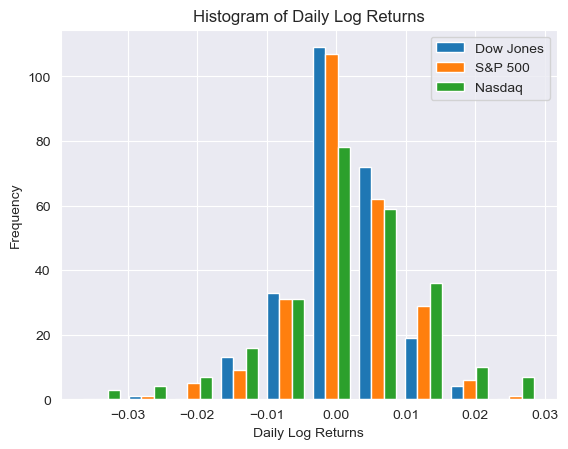

In [4]:
plt.hist(big3_data['Daily Log Return'], label=['Dow Jones', 'S&P 500', 'Nasdaq'])
plt.xlabel('Daily Log Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Log Returns')
plt.legend()

plt.show()

Furthermore, a Q-Q plot confirms this behavior.

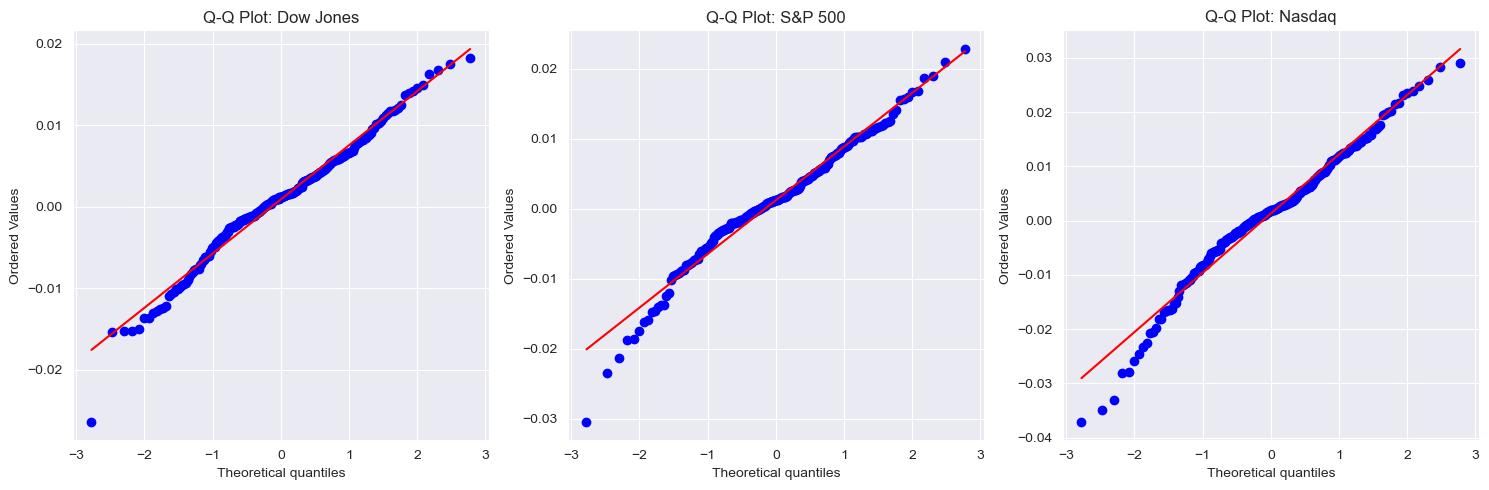

In [5]:

# Generate example datasets
data1 = big3_data['Daily Log Return']['^DJI']
data2 = big3_data['Daily Log Return']['^GSPC']
data3 = big3_data['Daily Log Return']['^IXIC']

datasets = [data1, data2, data3]
titles = ["Dow Jones", "S&P 500", "Nasdaq"]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (data, ax) in enumerate(zip(datasets, axes)):
    stats.probplot(data, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot: {titles[i]}")
    ax.grid(True)

plt.tight_layout()
plt.show()

The tendency of the left side of the Q-Q plot to fall below the theoretical quantiles suggests that the lower tail of the daily log returns is heavier than that of a standard normal distribution. This likely reflects the market’s long-term upward trend. To mitigate this effect, we restrict our analysis to a sliding window over shorter intervals and test for normality within each. We will implement a function to perform this test and show that, in most windows, the null hypothesis of normality is not rejected.

In [6]:
def p_dagost(tickers, start_date, end_date, window_length):

    # Downloads historical price data
    
    tickers_data = yf.download(tickers, start = start_date, end = end_date)

    # Append the log daily returns to the data

    tickers_data = daily_return_app(tickers_data)

    # Find the number of days as an integer

    num_days = len(tickers_data['Daily Log Return'])

    # Initialize minimum p-value array

    p_values_df = pd.DataFrame(index=range(num_days - window_length), columns=tickers)

    for i in range(num_days - window_length):

        # Extract daily log returns in the window

        window_data = tickers_data['Daily Log Return'].iloc[i:(window_length+i)]

        for ticker in tickers:

            # Finds the p value for the D'Agostino-Pearson normality test

            p_values_df.loc[i, ticker] = stats.normaltest(window_data[ticker])[1]

    return p_values_df

def p_sha(tickers, start_date, end_date, window_length):

    # Downloads historical price data
    
    tickers_data = yf.download(tickers, start = start_date, end = end_date)

    # Append the log daily returns to the data

    tickers_data = daily_return_app(tickers_data)

    # Find the number of days as an integer

    num_days = len(tickers_data['Daily Log Return'])

    # Initialize minimum p-value array

    p_values_df = pd.DataFrame(index=range(num_days - window_length), columns=tickers)

    for i in range(num_days - window_length):

        # Extract daily log returns in the window

        window_data = tickers_data['Daily Log Return'].iloc[i:(window_length+i)]

        for ticker in tickers:

            # Finds the p value for the D'Agostino-Pearson normality test

            p_values_df.loc[i, ticker] = stats.shapiro(window_data[ticker])[1]

    return p_values_df

In [7]:
p_dagost_df = p_dagost(big3, datetime(2023, 11, 1), datetime (2024, 11, 1), 50)

print(f"The dataframe of p values for the D'Agostino-Pearson test is: \n")

display(p_dagost_df)

print(f"The following dataframe tells us when we will reject the null hypothesis: \n")

display(p_dagost_df > 0.05)

print(f"Finally, the number of days we fail to reject normality is: \n{np.sum(p_dagost_df > 0.05, axis=0)}")

[*********************100%***********************]  3 of 3 completed


The dataframe of p values for the D'Agostino-Pearson test is: 



,^DJI,^GSPC,^IXIC
0,0.206769,0.11158,0.432762
1,0.279941,0.149495,0.290636
2,0.257399,0.143668,0.28796
3,0.410465,0.257387,0.43802
4,0.433666,0.250961,0.351335
...,...,...,...
196,0.805928,0.095141,0.038388
197,0.744573,0.042832,0.012157
198,0.68974,0.041874,0.011966
199,0.799034,0.034091,0.00902


The following dataframe tells us when we will reject the null hypothesis: 



,^DJI,^GSPC,^IXIC
0,True,True,True
1,True,True,True
2,True,True,True
3,True,True,True
4,True,True,True
...,...,...,...
196,True,True,False
197,True,False,False
198,True,False,False
199,True,False,False


Finally, the number of days we fail to reject normality is: 
^DJI     170
^GSPC    163
^IXIC    172
dtype: int64


Repeating the same analysis with the Shapiro-Wilks test yields:

In [8]:
p_sha_df = p_sha(big3, datetime(2023, 11, 1), datetime (2024, 11, 1), 50)

print(f"The dataframe of p values for the Shapiro-Wilk test is: \n")

display(p_sha_df)

print(f"The following dataframe tells us when we will reject the null hypothesis: \n")

display(p_sha_df > 0.05)

print(f"Finally, the number of days we fail to reject normality is: \n{np.sum(p_sha_df > 0.05, axis=0)}")

[*********************100%***********************]  3 of 3 completed


The dataframe of p values for the Shapiro-Wilk test is: 



,^DJI,^GSPC,^IXIC
0,0.115954,0.058584,0.194892
1,0.182586,0.199368,0.175713
2,0.15196,0.19488,0.177297
3,0.280527,0.345038,0.268757
4,0.313987,0.324371,0.157751
...,...,...,...
196,0.902552,0.221738,0.096126
197,0.851533,0.123829,0.04551
198,0.806966,0.123312,0.044785
199,0.894712,0.113158,0.029814


The following dataframe tells us when we will reject the null hypothesis: 



,^DJI,^GSPC,^IXIC
0,True,True,True
1,True,True,True
2,True,True,True
3,True,True,True
4,True,True,True
...,...,...,...
196,True,True,True
197,True,True,False
198,True,True,False
199,True,True,False


Finally, the number of days we fail to reject normality is: 
^DJI     182
^GSPC    181
^IXIC    173
dtype: int64


## Question 1 Conclusion:

In our analysis of the first question, we began by identifying a period of stability in the market. We then examined whether the log returns of major stock indices could be considered approximately normally distributed. Over the course of the full year, the distribution of returns appeared skewed—this was evident in both the histogram and the Q-Q plot. Additionally, two formal normality tests rejected the assumption of normality.

However, when we restricted our analysis to 50-day windows instead of the entire year, the data appeared much more well-behaved. In fact, we failed to reject the null hypothesis of normality in over 80% of these shorter time intervals. This suggests that, while the log returns of major stock indices are not normally distributed over long horizons, they can be reasonably approximated by a normal distribution over shorter time frames—though the fit is still imperfect.

---

# Question 2: How does removing outliers affect the distribution? Do we see more normal behavior?

## Finding Outliers and Removing Their Impact

We revisit the data from Question 1, where the long-term daily log returns of the Big 3 indices were found not to be normally distributed. Here, we define an outlier as any data point lying beyond three standard deviations from the mean. To begin analyzing the impact of these outliers, we will create a function to identify them.

In [9]:
def outlier_finder(ticker_df):

    # Appends the daily log return column to the data frame
    
    daily_return_app(ticker_df)

    # Finds the mean and standard deviation of the daily log returns

    mu = ticker_df['Daily Log Return'].mean()
    sigma = ticker_df['Daily Log Return'].std()

    # Returns a boolean if a data point is an outlier

    return np.abs(ticker_df['Daily Log Return'] - mu) < 3*sigma

With this function, we'll identify outliers using Boolean values. Then, for each ticker, we'll multiply the Boolean series by the series of daily log returns. By removing the resulting zeros from the DataFrame, we can test for normality again—with the added benefit that outliers have been excluded.

In [10]:
def outlier_remover(tickers, ticker_df):

    # Finds the outliers in the dataframe

    outlier_df = outlier_finder(ticker_df)

    # Initializes the dictionary of data with removed outliers

    outlier_removed = pd.DataFrame(index = ticker_df.index)

    for ticker in tickers:

        # Each row of the dataframe is set to 0 if the data point was an outlier

        outlier_removed[ticker] = outlier_df[ticker] * ticker_df['Daily Log Return'][ticker]

    # Replaces zeroes with NaN

    outlier_removed = outlier_removed.replace(0, np.nan)

    return outlier_removed


big3_data_no_out = outlier_remover(big3, big3_data)

big3_data_no_out


,^DJI,^GSPC,^IXIC
Date,,,
2023-11-02,0.016823,0.018683,0.017660
2023-11-03,0.006546,0.009350,0.013752
2023-11-06,0.001014,0.001751,0.003000
2023-11-07,0.001663,0.002836,0.008917
2023-11-08,-0.001182,0.001004,0.000773
...,...,...,...
2024-10-25,-0.006154,-0.000299,0.005584
2024-10-28,0.006465,0.002648,0.002620
2024-10-29,-0.003652,0.001613,0.007809


## Testing for Normality

Now we can remove the NaN entries and rerun the same series of tests as before. To this end, we'll write a few functions to handle the process and compute the p-values for standard normality tests.

In [11]:
def p_sha_no_out(tickers, ticker_df):

    # Initializes the dataframe of p-values

    p_sha_df = pd.DataFrame(index=[0])
    
    for ticker in tickers:

        # Removes any outliers (labeled by NaN entries)

        current_ser = ticker_df[ticker].dropna()

        # Performs the Shapiro-Wilks test for each ticker

        p_sha_df.loc[0, ticker] = stats.shapiro(current_ser)[1]

    return p_sha_df

def p_dagost_no_out(tickers, ticker_df):

    # Initializes the dataframe of p-values

    p_sha_df = pd.DataFrame(index=[0])
    
    for ticker in tickers:

        # Removes any outliers (labeled by NaN entries)

        current_ser = ticker_df[ticker].dropna()

        # Performs the Shapiro-Wilks test for each ticker

        p_sha_df.loc[0, ticker] = stats.normaltest(current_ser)[1]

    return p_sha_df

# Creates a single dataframe of the p-values from the respective tests

p_values_no_out = pd.concat([p_sha_no_out(big3, big3_data_no_out),p_dagost_no_out(big3, big3_data_no_out)])

p_values_no_out.index = ['Shapiro', "D'Agostino"]
p_values_no_out.columns = ['Dow Jones', 'S&P 500', 'Nasdaq']

print("The table of p-values of the Shapiro-Wilk test and the D'Agostino-Pearson test")

p_values_no_out

The table of p-values of the Shapiro-Wilk test and the D'Agostino-Pearson test


,Dow Jones,S&P 500,Nasdaq
Shapiro,0.024836,0.030518,0.023857
D'Agostino,0.389207,0.094593,0.129919


We observe that we still reject the null hypothesis in the Shapiro-Wilk test. However, after removing the outliers, we fail to reject the null hypothesis in the D’Agostino-Pearson test. Finally, a Q-Q plot of the data sets shows that the data with outliers removed is less skewed.

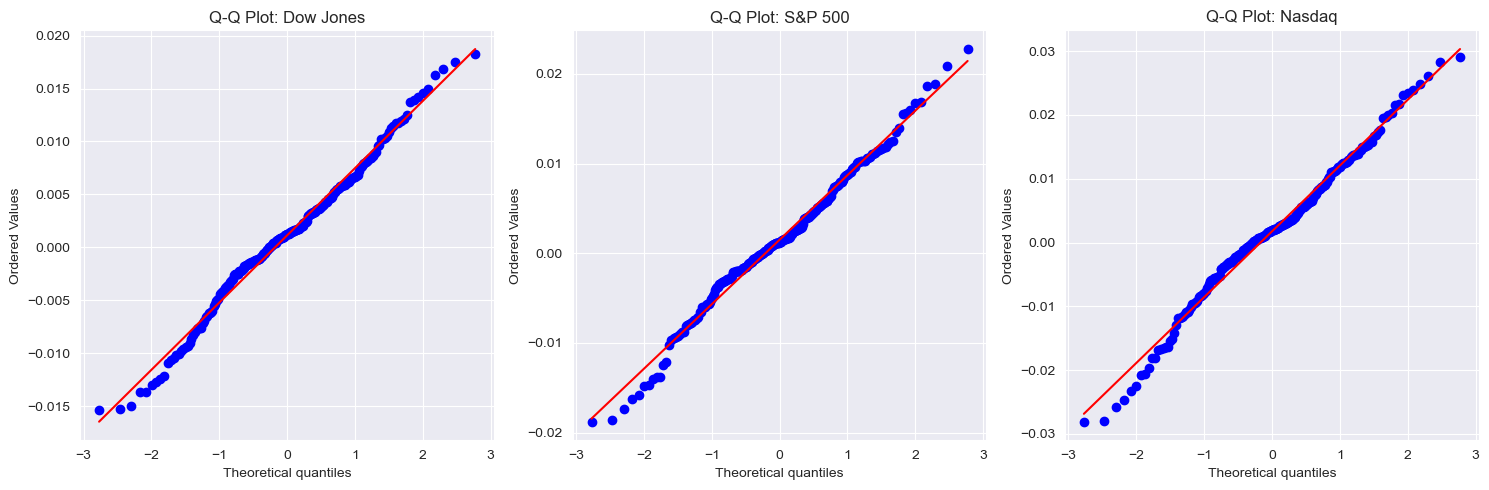

In [12]:
# Generate example datasets
data1 = big3_data_no_out.dropna()['^DJI']
data2 = big3_data_no_out.dropna()['^GSPC']
data3 = big3_data_no_out.dropna()['^IXIC']

datasets = [data1, data2, data3]
titles = ["Dow Jones", "S&P 500", "Nasdaq"]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (data, ax) in enumerate(zip(datasets, axes)):
    stats.probplot(data, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot: {titles[i]}")
    ax.grid(True)

plt.tight_layout()
plt.show()

## Question 2 Conclusion

To investigate whether removing outliers significantly improves the normality of our data, we observed a clear positive effect. Once outliers were excluded, we no longer rejected the null hypothesis in the D’Agostino-Pearson test, and the Q-Q plots demonstrated noticeably improved behavior in the distribution tails. These findings suggest that trimming extreme values can help data conform more closely to a normal distribution.

This naturally raises the question of whether excluding outliers leads to more accurate modeling and better predictions. While the improved normality is encouraging, it is important to recognize that outliers are often unpredictable events. Thus, relying solely on outlier removal may oversimplify the data and overlook potentially important information. Further investigation is needed to balance model accuracy and the realistic handling of extreme events.

---

# Question 3: We saw that the major indices were approximately normally distributed—what about individual stocks of major companies?

## Testing for Normality Among S&P 100 Companies

In this analysis, we again focus the S&P 100 companies found in the "safe" portfolio from the previous project. To ensure consistency, we'll limit our examination to the same period of market stability identified in Question 1.

In [13]:
# The tickers in S&P 100

port_tickers = [
    'KO', 'LIN', 'DUK', 'SO', 'MO','JNJ', 'PG', 'PEP', 'BRK-B', 'MCD'
]

# Fetches historical data

port_data = yf.download(port_tickers, start="2023-11-01", end="2024-11-01")

# Appends the daily log returns to the dataframe

port_data = daily_return_app(port_data)
port_data_dlc = daily_return_app(port_data)['Daily Log Return']

port_data

[*********************100%***********************]  10 of 10 completed


Close                                                 \
Ticker           BRK-B         DUK         JNJ         KO         LIN   
Date                                                                    
2023-11-02  349.019989   83.830292  142.107040  54.172646  381.286469   
2023-11-03  351.809998   84.194008  143.147476  53.840534  384.075256   
2023-11-06  346.630005   83.671761  143.487991  54.058777  384.554657   
2023-11-07  346.170013   83.261414  142.731308  54.258045  380.934174   
2023-11-08  346.299988   82.403435  142.211105  54.172646  383.830566   
...                ...         ...         ...        ...         ...   
2024-10-25  454.010010  114.001724  156.986191  65.464272  469.260498   
2024-10-28  458.489990  113.855827  157.688766  65.219711  471.479187   
2024-10-29  454.619995  111.278366  156.215302  64.133850  470.151917   
2024-10-30  454.959991  110.879585  156.722733  64.486023  468.903870   
2024-10-31  450.920013  112.114822  155.990875  63.889294  451.817688   

                                                                      ...  \
Ticker             MCD         MO         PEP          PG         SO  ...   
Date                                                                  ...   
2023-11-02  256.045563  35.327839  157.298080  145.956055  65.840286  ...   
2023-11-03  257.024261  35.327839  157.260345  144.635696  66.093788  ...   
2023-11-06  258.022186  35.214912  157.175476  145.474197  65.004601  ...   
2023-11-07  257.791870  35.188847  157.628067  145.136841  64.525742  ...   
2023-11-08  256.659637  34.919571  157.826080  144.577835  64.413048  ...   
...                ...        ...         ...         ...        ...  ...   
2024-10-25  287.559662  47.082115  167.014160  166.164703  89.607208  ...   
2024-10-28  291.667572  47.593567  165.118378  167.231506  89.519440  ...   
2024-10-29  289.908417  47.309429  162.843430  165.127533  87.598167  ...   
2024-10-30  286.488464  47.830353  161.589310  164.129868  87.149551  ...   
2024-10-31  287.068298  51.581013  161.462906  163.161835  88.778236  ...   

           Daily Log Return                                                    \
Ticker                BRK-B       DUK       JNJ        KO       LIN       MCD   
Date                                                                            
2023-11-02         0.015215  0.003901  0.010370  0.011451  0.006591  0.018457   
2023-11-03         0.007962  0.004329  0.007295 -0.006149  0.007288  0.003815   
2023-11-06        -0.014833 -0.006222  0.002376  0.004045  0.001247  0.003875   
2023-11-07        -0.001328 -0.004916 -0.005287  0.003679 -0.009459 -0.000893   
2023-11-08         0.000375 -0.010358 -0.003651 -0.001575  0.007575 -0.004402   
...                     ...       ...       ...       ...       ...       ...   
2024-10-25        -0.008248 -0.015324 -0.017193 -0.005662 -0.001476 -0.030195   
2024-10-28         0.009819 -0.001281  0.004465 -0.003743  0.004717  0.014184   
2024-10-29        -0.008477 -0.022898 -0.009388 -0.016789 -0.002819 -0.006050   
2024-10-30         0.000748 -0.003590  0.003243  0.005476 -0.002658 -0.011867   
2024-10-31        -0.008920  0.011079 -0.004681 -0.009297 -0.037119  0.002022   

                                                    
Ticker            MO       PEP        PG        SO  
Date                                                
2023-11-02  0.019115  0.011818  0.012158  0.024397  
2023-11-03  0.000000 -0.000240 -0.009087  0.003843  
2023-11-06 -0.003202 -0.000540  0.005781 -0.016617  
2023-11-07 -0.000740  0.002875 -0.002322 -0.007394  
2023-11-08 -0.007682  0.001255 -0.003859 -0.001748  
...              ...       ...       ...       ...  
2024-10-25 -0.004616 -0.002152 -0.008288 -0.018654  
2024-10-28  0.010804 -0.011416  0.006400 -0.000980  
2024-10-29 -0.005988 -0.013873 -0.012661 -0.021696  
2024-10-30  0.010951 -0.007731 -0.006060 -0.005134  
2024-10-31  0.075493 -0.000783 -0.005915  0.018516  

[251 rows x 60 columns]

In [14]:
# Finds the p values for the Shapiro-Wilk test and the D'Agostino-Pearson test

p_sha_df = port_data['Daily Log Return'].apply(lambda x: stats.shapiro(x)[1])
p_dagost_df = port_data['Daily Log Return'].apply(lambda x: stats.normaltest(x)[1])

# Concatenates the results into one dataframe

p_port = pd.concat([p_sha_df, p_dagost_df], axis = 1)
p_port.columns = ['Shapiro', "D'Agostino"]

p_port

,Shapiro,D'Agostino
Ticker,,
BRK-B,1.648115e-03,6.226698e-05
DUK,1.375984e-01,7.643966e-02
JNJ,2.713027e-05,6.104397e-06
KO,2.394675e-02,1.400893e-01
LIN,1.516179e-11,1.654183e-14
MCD,6.826398e-07,1.401764e-08
MO,1.382027e-11,6.342380e-19
PEP,3.247363e-05,1.384215e-04
PG,1.099109e-08,2.299517e-10


These p-values indicate that none of the data is normally distributed. This result is not surprising: while the Big Three indices are exceedingly well-behaved, the data here is slightly more volatile. We'll examine histograms of the distributions to better understand the deviations from normality.

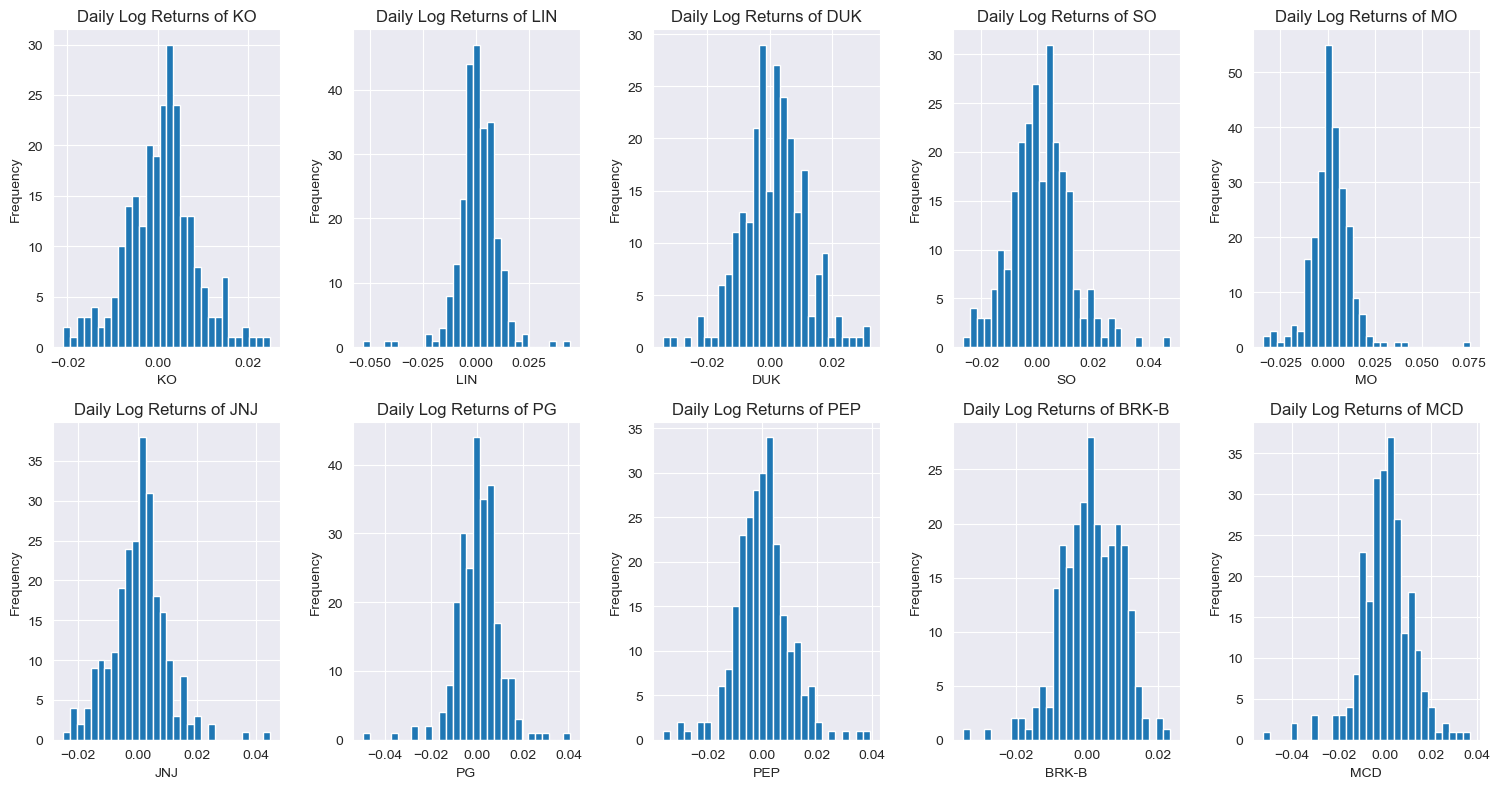

In [15]:
fig, axes = plt.subplots(2,5, figsize = (15,8))

axes = axes.flatten()

for i, ticker in enumerate(port_tickers):

    axes[i].hist(port_data['Daily Log Return'][ticker], bins = 30)
    axes[i].set_title(f'Daily Log Returns of {ticker}')
    axes[i].set_xlabel(ticker)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

These plots allow us to make two key observations about our data: most of the histograms are slightly right-skewed, as we saw previously, and about half exhibit a somewhat bimodal distribution. Earlier, we conjectured that right skewness might indicate a healthy, growing company. The appearance of bimodality, however, is new. It likely reflects a period of financial turbulence—such as sudden gains or sharp losses—in the company’s performance. We will explore this hypothesis further by examining the closing prices over the same time window.

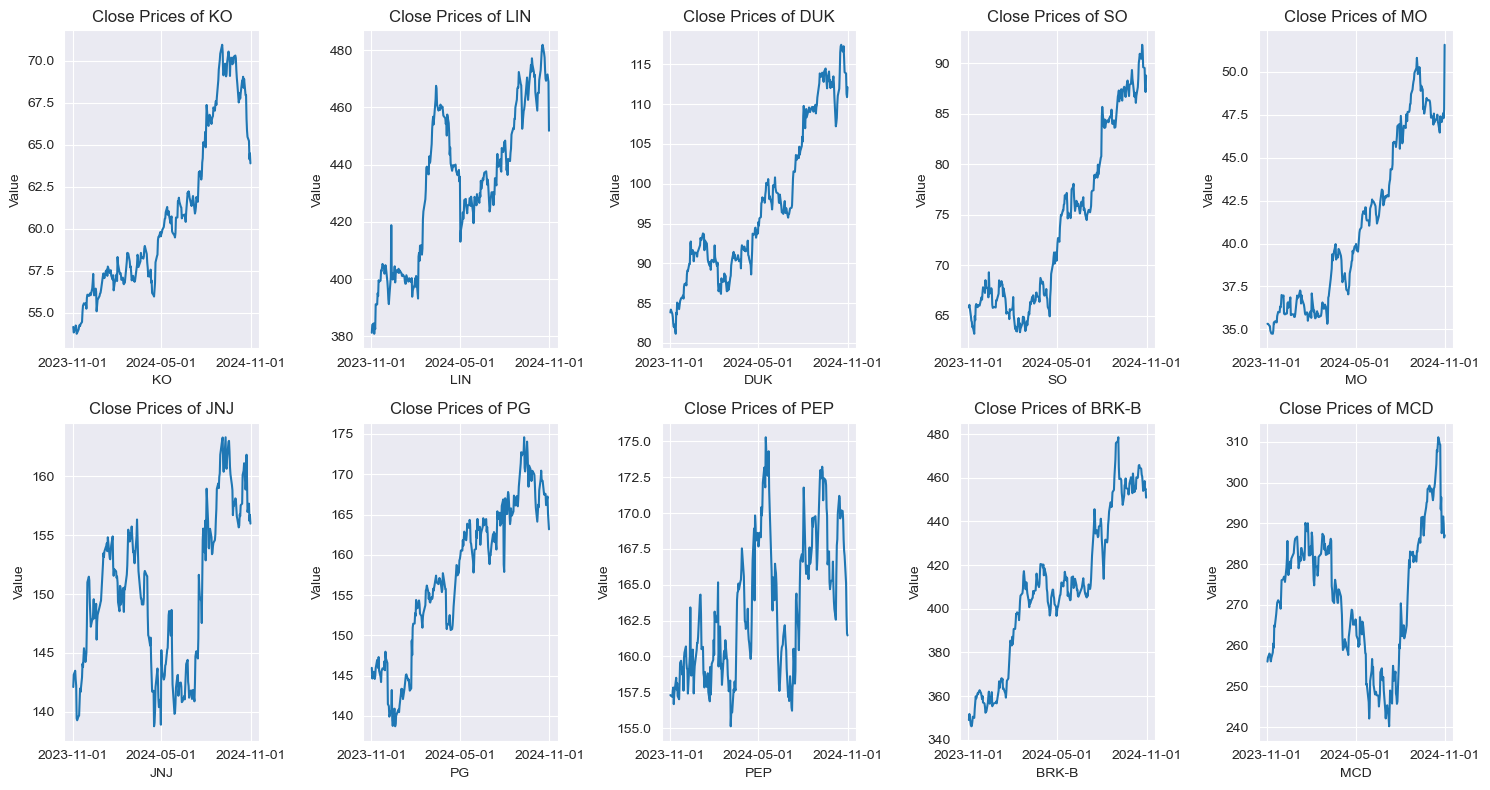

In [16]:
fig, axes = plt.subplots(2,5, figsize = (15,8))

axes = axes.flatten()

for i, ticker in enumerate(port_tickers):

    axes[i].plot(port_data['Close'][ticker])
    axes[i].set_title(f'Close Prices of {ticker}')
    axes[i].set_xlabel(ticker)
    axes[i].set_xticks(axes[i].get_xticks()[::3])
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

Two of the companies displaying a bimodal distribution—Southern Co and Duke Energy Corp—exhibit large upward jumps but otherwise behave consistently throughout the year. The data also reveals that PepsiCo, the only company clearly exhibiting left-skewness, experienced a highly volatile year. These observations lead us to conjecture that, even after removing outliers, much of the data will still deviate from a normal distribution. However, as in Question 1, we expect that reducing the data window will reveal periods in which the data appears approximately normal with relative frequency. We test this by applying the functions developed in the previous two analyses.

## Sliding Window Test Results

We begin by testing how many windows in the sliding window approach fail to reject the null hypothesis.

In [17]:
p_dagost_df = p_dagost(port_tickers, datetime(2023, 11, 1), datetime (2024, 11, 1), 50)

print(f"The dataframe of p values for the D'Agostino-Pearson test is: \n")

display(p_dagost_df)

print(f"The following dataframe tells us when we will reject the null hypothesis: \n")

display(p_dagost_df > 0.05)

print(f"Finally, the number of days we fail to reject normality is:")

display(np.sum(p_dagost_df > 0.05, axis=0))

[*********************100%***********************]  10 of 10 completed


The dataframe of p values for the D'Agostino-Pearson test is: 



,KO,LIN,DUK,SO,MO,JNJ,PG,PEP,BRK-B,MCD
0,0.004324,0.000175,0.031589,0.060015,0.010635,0.203528,0.000181,0.720772,0.611529,0.684877
1,0.002464,0.000157,0.041364,0.025504,0.005704,0.185027,0.000113,0.582858,0.544783,0.522315
2,0.000867,0.000138,0.041876,0.022402,0.008493,0.175405,0.000078,0.60214,0.553677,0.609154
3,0.002297,0.000137,0.040245,0.017812,0.008293,0.174998,0.000111,0.702814,0.66307,0.72794
4,0.00477,0.000109,0.04047,0.018332,0.007606,0.133405,0.000088,0.708584,0.59323,0.812704
...,...,...,...,...,...,...,...,...,...,...
196,0.218399,0.407544,0.004148,0.24725,0.546137,0.433875,0.77733,0.025825,0.00958,0.0
197,0.282209,0.4801,0.00989,0.46551,0.470439,0.392589,0.826079,0.02415,0.020958,0.0
198,0.349822,0.442972,0.011535,0.426276,0.459253,0.374409,0.869019,0.032909,0.022903,0.0
199,0.360758,0.516157,0.02669,0.583398,0.553301,0.502193,0.967697,0.033993,0.039475,0.0


The following dataframe tells us when we will reject the null hypothesis: 



,KO,LIN,DUK,SO,MO,JNJ,PG,PEP,BRK-B,MCD
0,False,False,False,True,False,True,False,True,True,True
1,False,False,False,False,False,True,False,True,True,True
2,False,False,False,False,False,True,False,True,True,True
3,False,False,False,False,False,True,False,True,True,True
4,False,False,False,False,False,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...
196,True,True,False,True,True,True,True,False,False,False
197,True,True,False,True,True,True,True,False,False,False
198,True,True,False,True,True,True,True,False,False,False
199,True,True,False,True,True,True,True,False,False,False


Finally, the number of days we fail to reject normality is:


KO       150
LIN       62
DUK      177
SO       139
MO        87
JNJ      143
PG        47
PEP      122
BRK-B    139
MCD      102
dtype: int64

In [18]:
p_sha_df = p_sha(port_tickers, datetime(2023, 11, 1), datetime (2024, 11, 1), 50)

print(f"The dataframe of p values for the Shapiro-Wilk test is: \n")

display(p_sha_df)

print(f"The following dataframe tells us when we will reject the null hypothesis: \n")

display(p_sha_df > 0.05)

print(f"Finally, the number of days we fail to reject normality is: \n{np.sum(p_sha_df > 0.05, axis=0)}")

[*********************100%***********************]  10 of 10 completed


The dataframe of p values for the Shapiro-Wilk test is: 



,KO,LIN,DUK,SO,MO,JNJ,PG,PEP,BRK-B,MCD
0,0.036845,0.000006,0.072334,0.088231,0.000729,0.153625,0.004007,0.939696,0.875902,0.898199
1,0.027559,0.000005,0.121681,0.076941,0.000376,0.110574,0.002582,0.794989,0.882111,0.866472
2,0.011593,0.000004,0.160616,0.067537,0.000785,0.096139,0.001742,0.781104,0.882174,0.869445
3,0.025599,0.000004,0.129766,0.05766,0.000739,0.096246,0.001927,0.810172,0.948468,0.757134
4,0.048906,0.000002,0.1349,0.051305,0.000959,0.05099,0.001767,0.910969,0.941051,0.790587
...,...,...,...,...,...,...,...,...,...,...
196,0.200526,0.399339,0.06164,0.333793,0.846167,0.153398,0.828092,0.227249,0.1275,0.000001
197,0.267672,0.568899,0.098205,0.491131,0.876413,0.135517,0.841042,0.186858,0.207027,0.000001
198,0.38108,0.505708,0.117496,0.561743,0.887176,0.128014,0.887272,0.242053,0.212929,0.000001
199,0.263754,0.604299,0.203676,0.659184,0.940216,0.227465,0.893498,0.251211,0.310191,0.0


The following dataframe tells us when we will reject the null hypothesis: 



,KO,LIN,DUK,SO,MO,JNJ,PG,PEP,BRK-B,MCD
0,False,False,True,True,False,True,False,True,True,True
1,False,False,True,True,False,True,False,True,True,True
2,False,False,True,True,False,True,False,True,True,True
3,False,False,True,True,False,True,False,True,True,True
4,False,False,True,True,False,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...
196,True,True,True,True,True,True,True,True,True,False
197,True,True,True,True,True,True,True,True,True,False
198,True,True,True,True,True,True,True,True,True,False
199,True,True,True,True,True,True,True,True,True,False


Finally, the number of days we fail to reject normality is: 
KO       147
LIN       86
DUK      188
SO       151
MO        89
JNJ      146
PG        47
PEP      132
BRK-B    147
MCD      100
dtype: int64


As expected, for most of the stocks, we fail to reject the null hypothesis more often than not. However, we now observe that the null is being rejected more frequently than it was for the three major indices. Notably, in both tests, we reject the null hypothesis more often than not for Linde PLC, Altria Group Inc., and Procter & Gamble Co.

## Outlier Removal Test Results

We now apply the outlier removal function developed in Question 2 and analyze the resulting p-values.

In [19]:
# Creates a single dataframe of the p-values from the respective tests

p_values_no_out = pd.concat([p_sha_no_out(port_tickers, port_data_dlc),p_dagost_no_out(port_tickers, port_data_dlc)])

p_values_no_out.index = ['Shapiro', "D'Agostino"]


print("The table of p-values of the Shapiro-Wilk test and the D'Agostino-Pearson test")

p_values_no_out

The table of p-values of the Shapiro-Wilk test and the D'Agostino-Pearson test


,KO,LIN,DUK,SO,MO,JNJ,PG,PEP,BRK-B,MCD
Shapiro,0.023947,1.516179e-11,0.137598,0.002934,1.382027e-11,0.000027,1.099109e-08,0.000032,0.001648,6.826398e-07
D'Agostino,0.140089,1.654183e-14,0.076440,0.000234,6.342380e-19,0.000006,2.299517e-10,0.000138,0.000062,1.401764e-08


As expected, even after removing outliers, the data remains irregular enough to reject the hypothesis of normality. The following Q-Q plots will provide a visual aid that further supports this conclusion.

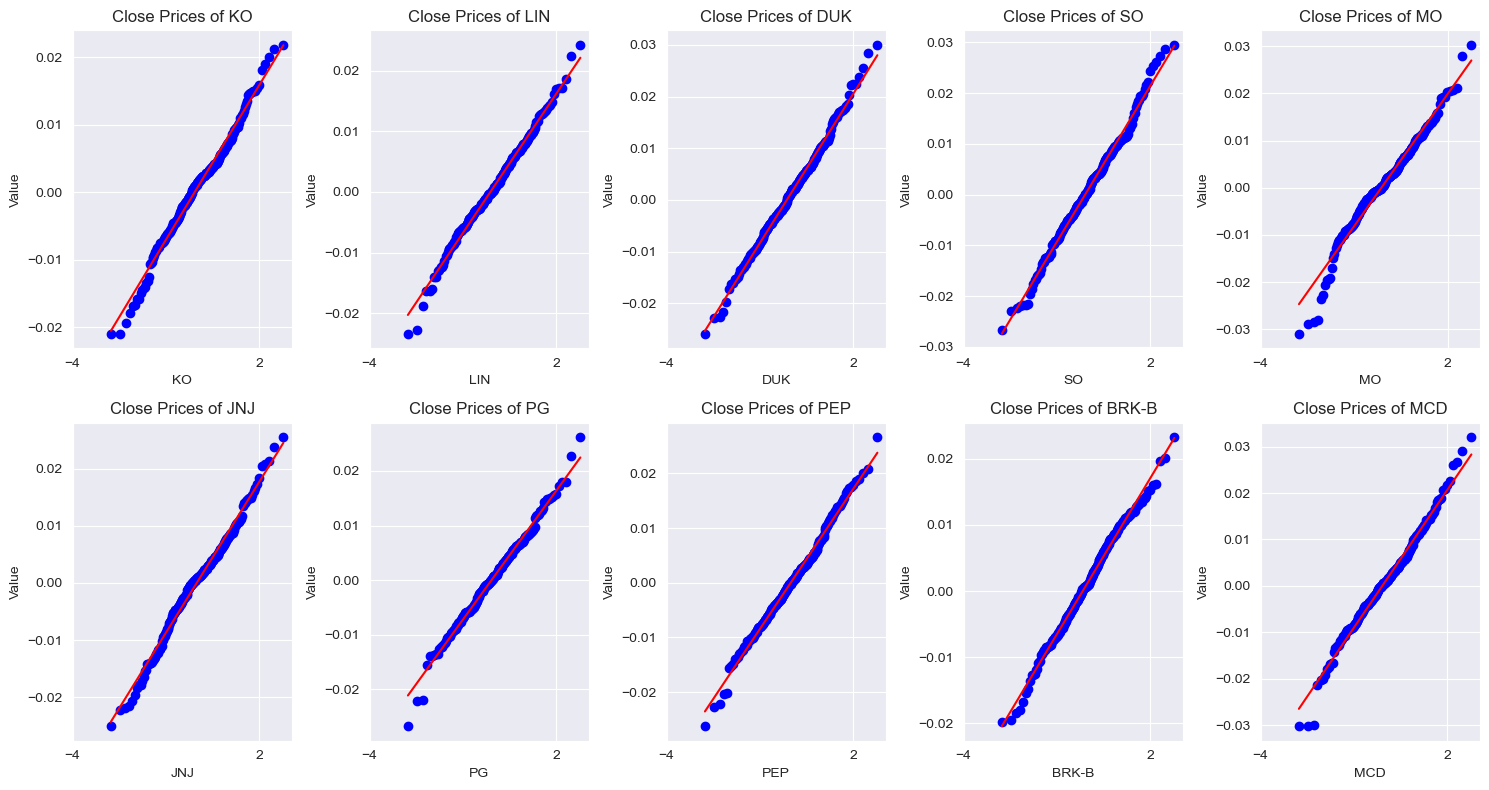

In [20]:
fig, axes = plt.subplots(2,5, figsize = (15,8))

axes = axes.flatten()

to_plot_df = outlier_remover(port_tickers,port_data)

for i, ticker in enumerate(port_tickers):

    stats.probplot(to_plot_df[ticker].dropna(), dist = 'norm', plot=axes[i])
    axes[i].set_title(f'Close Prices of {ticker}')
    axes[i].set_xlabel(ticker)
    axes[i].set_xticks(axes[i].get_xticks()[::3])
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

This shows that, while most of the data near the center follows a normal distribution, there remain non-outlier points causing significant deviations from normality.

## Question 3 Conclusion

After selecting a group of stocks with minimal volatility (see Project 1), we ran the same normality tests on this subset. We observed that, although these stocks behaved only slightly less consistently than the big three indices, the assumption of normality became more questionable. For some stocks, one could confidently say they failed every normality test, including those with more relaxed criteria. However, the Q-Q plots mostly aligned with the normal distribution across all stocks, and some assumptions are necessary to proceed with analysis. Therefore, it is reasonable to claim that the log returns of these stocks are relatively normally distributed.

---

# Conclusion

In this project, we examined the widely used assumption that the logarithmic returns of several stocks and market indices follow an approximately normal distribution. Initial statistical tests, such as the Shapiro-Wilk and D'Agostino-Pearson tests, indicated that the null hypothesis of normality should often be rejected at conventional significance levels.

However, analysis of Q-Q plots revealed that the primary reasons for rejection were systematic left skewness and the presence of jumps or extreme outliers in the return distributions. This observation suggests that while the tails deviate from normality, the central portion of the distribution—which corresponds to moderate daily returns—may still be well-approximated by a normal distribution.

To investigate this further, we designed two complementary tests:

A rolling window normality test, where the return series was partitioned into overlapping windows (50 trading days). Normality tests were applied to each window independently, and we recorded the proportion of windows where the null hypothesis was rejected. This allowed us to assess the temporal stability of the normality assumption.

An outlier-robust test, in which extreme return values—identified by thresholding standardized residuals or using interquartile range criteria—were removed before conducting the normality tests. This procedure isolates the effect of jumps and heavy tails on the rejection of normality.

Applying these tests to the major US indices (e.g., S&P 500, Dow Jones, Nasdaq) as well as the diversified portfolio constructed in Project 1 revealed that the assumption of normality is not entirely baseless. While deviations due to skewness and kurtosis exist, the core of the distribution often behaves in a manner consistent with normality. Therefore, normality should be viewed as a useful but imperfect approximation, particularly in applications such as risk modeling or portfolio optimization where extreme events may have disproportionate impact.

---

# Q&A

### Question: Why didn't you use the rolling window test with the outliers removed, thereby combining the two tests into one?

While both tests effectively demonstrate that the data often behaves approximately normally, each also highlights deviations from normality in different ways. Combining them risked further obscuring these important deviations. Additionally, since each test individually produced the desired insights, combining them was ultimately deemed unnecessary.

---